# Blake Conrad
HW 4-5 Advanced Simulations

In [1]:
import pandas as pd
import numpy as np


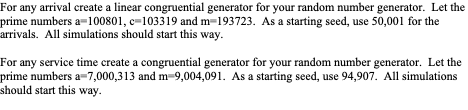

In [10]:
def seed_lcg_arrival(initVal):
    global rand_arrival
    rand_arrival = initVal
    
def seed_cg_service(initVal):
    global rand_service
    rand_service = initVal

def lcg_arrival():
    a = 100801
    c = 103319
    m = 193723
    global rand_arrival
    rand_arrival = (a*rand_arrival + c) % m
    return rand_arrival / m

def cg_service():
    a = 7000313 
    m = 9004091
    global rand_service
    rand_service = (a*rand_service) % m
    return rand_service / m

ARRIVAL_SEED = 50001
SERVICE_SEED = 94907
seed_lcg_arrival(ARRIVAL_SEED)
seed_cg_service(SERVICE_SEED)

print("10 Arrivals")
for i in range(10):
    print(lcg_arrival())
print("10 Services")
for j in range(10):
    print(cg_service())

10 Arrivals
0.8405248731436122
0.2810714267278537
0.8142192718469154
0.6501551183906918
0.8194225775979104
0.1485781244354052
0.35685489074606525
0.8631757715913959
0.514285861771705
0.062486127099002184
10 Services
0.3162301447197724
0.9930737039419082
0.7596626911034107
0.612146189992971
0.9317082646099423
0.47695641903219327
0.2205845098633499
0.6119950364784186
0.8097953474703887
0.8982364793958657


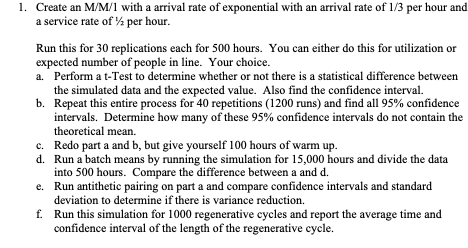

In [17]:
def getArrival(time, rate=3):
    #–ln(u)/λ
    return lcg_arrival() + time
    #return np.random.exponential(scale=rate) + time
#getArrival(0.0)

def getDeparture(time, rate=2):
    #–ln(u)/λ
    return cg_service() + time
    #return np.random.exponential(scale=rate) + time
#getDeparture(0.0)

def addRow(tmp, insert_dict, index):
    keys=list(insert_dict.keys())
    assert('rep' in keys, "rep not in dictionary for insertion.")
    assert('recordType' in keys, "recordType not in dictionary for insertion.")
    assert('time' in keys, "time not in dictionary for insertion.")
    assert('nextArrival' in keys, "nextArrival not in dictionary for insertion.")
    assert('nextDeparture' in keys, "nextDeparture not in dictionary for insertion.")
    assert('utilization' in keys, "utilization not in dictionary for insertion.")
    assert('queueLength' in keys, "queueLength not in dictionary for insertion.")
    assert('totalTimeInLine' in keys, "totalTimeInLine not in dictionary for insertion.")
    assert('totalTimeInSystem' in keys, "totalTimeInSystem not in dictionary for insertion.")
    tmp.loc[index]=[insert_dict['rep'],
                    insert_dict['recordType'],
                    insert_dict['time'],
                    insert_dict['nextArrival'],
                    insert_dict['nextDeparture'],
                    insert_dict['utilization'],
                    insert_dict['queueLength'],
                    insert_dict['totalTimeInLine'],
                    insert_dict['totalTimeInSystem']]
    index+=1
    return tmp, index



<ipython-input-17-9fbd88227ffd>:15: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert('rep' in keys, "rep not in dictionary for insertion.")
<ipython-input-17-9fbd88227ffd>:16: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert('recordType' in keys, "recordType not in dictionary for insertion.")
<ipython-input-17-9fbd88227ffd>:17: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert('time' in keys, "time not in dictionary for insertion.")
<ipython-input-17-9fbd88227ffd>:18: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert('nextArrival' in keys, "nextArrival not in dictionary for insertion.")
<ipython-input-17-9fbd88227ffd>:19: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert('nextDeparture' in keys, "nextDeparture not in dictionary for insertion.")
<ipython-input-17-9fbd88227ffd>:20: SyntaxWarning: assertion is always true, perhaps remove parentheses

In [136]:
num_times_true_mean_not_in_ci=0
for j in range(1):
    dfs=[]
    for rep in range(30):
        df = pd.DataFrame({'Rep':[],
                        'RecordType':[],
                       'Time':[],
                        'NextArrival':[],
                        'NextDeparture':[],
                        'Utilization':[],
                        'QueueLength':[],
                        'TotalWaitingTimeInLine':[],
                        'TotalWaitingTimeSystem':[]})
        time=0.0
        oldTime=0.0
        nextDeparture=M
        nextArrival=getArrival(time)
        utilization=0
        queueLength=0
        totalTimeInLine=0
        totalTimeInSystem=0
        index_count=0

        M=1000000
        insertDict={'rep':rep,'recordType':'A','oldTime':oldTime, 'time':time, 
                     'nextArrival':nextArrival,
                     'nextDeparture':nextDeparture,
                     'utilization':0, 
                     'queueLength':0, 
                     'totalTimeInLine':0, 
                     'totalTimeInSystem':0}
        df, idx=addRow(df, insertDict ,index_count)
        while time <= 500:

            # Update time
            oldTime=time

            # Template for next record in db
            insertDict={'rep':rep,'recordType':'','time':0, 
                     'nextArrival':0,
                     'nextDeparture':0,
                     'utilization':0, 
                     'queueLength':0, 
                     'totalTimeInLine':0, 
                     'totalTimeInSystem':0}

            # Handle arrival record
            if nextArrival < nextDeparture:
                time=getArrival(time)
                delta=time-oldTime
                totalTimeInLine=delta*queueLength + totalTimeInLine
                totalTimeInSystem=(utilization+queueLength)*delta + totalTimeInSystem
                if utilization==0:
                    utilization=1
                    nextDeparture=time+getDeparture(time)
                else:
                    queueLength+=1

                # Insert information
                if time >= 100: #warmup
                    nextArrival = time + getArrival(time)
                    insertDict['rep']=rep
                    insertDict['recordType']='A'
                    insertDict['time']=time
                    insertDict['nextArrival']=nextArrival
                    insertDict['nextDeparture']=nextDeparture
                    insertDict['utilization']=utilization
                    insertDict['queueLength']=queueLength
                    insertDict['totalTimeInLine']=totalTimeInLine
                    insertDict['totalTimeInSystem']=totalTimeInSystem

                    # Add arrival record
                    df, idx = addRow(df,insertDict, idx)

            # Handle departure record
            else:
                time=nextDeparture
                if queueLength >= 1:
                    queueLength -= 1
                    nextDeparture = time + getDeparture(time)
                else:
                    utilization=0
                    nextDeparture=M
                    oldTime=time

                # Insert information
                if time >= 100:
                    insertDict['rep']=rep
                    insertDict['recordType']='D'
                    insertDict['time']=time
                    insertDict['nextArrival']=nextArrival
                    insertDict['nextDeparture']=nextDeparture
                    insertDict['utilization']=utilization
                    insertDict['queueLength']=queueLength
                    insertDict['totalTimeInLine']=totalTimeInLine
                    insertDict['totalTimeInSystem']=totalTimeInSystem

                    # Add departure record
                    df, idx = addRow(df,insertDict, idx)
                
        dfs.append(df)
    df=pd.concat(dfs)

    # Simulated expected length in queue
    Lq=df.groupby('Rep')["Utilization","QueueLength"].sum().sum(axis=1)/(df.groupby('Rep')["TotalWaitingTimeInLine"].idxmax())
    mu_hat=Lq[Lq!=np.inf].mean()
    rep_means=np.array(Lq[Lq!=np.inf])
    mu=((1/3)/(1/2))/(1-((1/3)/(1/2)))

    t,p=ttest_1samp(rep_means, popmean=mu)
    print(p)
    if p < 0.05:
        print("Reject the null that the means are the same.")

    import scipy.stats

    def mean_confidence_interval(data, confidence=0.95):
        a = 1.0 * np.array(data)
        n = len(a)
        m, se = np.mean(a), scipy.stats.sem(a)
        h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
        return m, m-h, m+h

    m,l,u=mean_confidence_interval(rep_means)
    print("If we re-run this experiment 100 times, we expect to see 95 of the means between {} and {}".format(l,u))
    if mu <= l or mu >= u:
        num_times_true_mean_not_in_ci+=1
print(num_times_true_mean_not_in_ci)
dfs[0]

6.334801008906407e-41
Reject the null that the means are the same.
If we re-run this experiment 100 times, we expect to see 95 of the means between 229.56014374752644 and 237.2862848239022
1


,Rep,RecordType,Time,NextArrival,NextDeparture,Utilization,QueueLength,TotalWaitingTimeInLine,TotalWaitingTimeSystem
0,0.0,A,0.000000,0.736799,1000000.000000,0.0,0.0,0.000000,0.000000
1,0.0,A,100.350784,200.953976,2.160839,1.0,210.0,10032.351796,10132.047811
2,0.0,D,159.430756,200.953976,319.074006,1.0,203.0,10032.351796,10132.047811
3,0.0,A,159.820628,320.571805,319.074006,1.0,204.0,10111.495630,10211.581516
4,0.0,D,319.074006,320.571805,638.973111,1.0,203.0,10111.495630,10211.581516
5,0.0,A,320.010333,640.212682,638.973111,1.0,204.0,10301.569932,10402.592144
6,0.0,D,638.973111,640.212682,1278.829022,1.0,203.0,10301.569932,10402.592144


In [99]:
1-(40/1200) # do not contain the theoretical mean.

0.9666666666666667

In [129]:
dfs[1]


,Rep,RecordType,Time,NextArrival,NextDeparture,Utilization,QueueLength,TotalWaitingTimeInLine,TotalWaitingTimeSystem
0,1.0,A,0.000000,0.34173,1000000.000000,0.0,0.0,0.000000,0.000000
1,1.0,D,0.279466,0.34173,1.002281,1.0,0.0,0.000000,0.000000
2,1.0,D,1.269271,0.34173,1.002281,1.0,1.0,0.000000,0.989805
3,1.0,D,2.139524,0.34173,1.002281,1.0,2.0,0.870253,2.730311
4,1.0,D,3.034105,0.34173,1.002281,1.0,3.0,2.659416,5.414055
5,1.0,D,3.271016,0.34173,1.002281,1.0,4.0,3.370147,6.361697
6,1.0,D,3.613004,0.34173,1.002281,1.0,5.0,4.738100,8.071638
7,1.0,D,3.909257,0.34173,1.002281,1.0,6.0,6.219365,9.849156
8,1.0,D,4.030879,0.34173,1.002281,1.0,7.0,6.949097,10.700511
9,1.0,D,4.194515,0.34173,1.002281,1.0,8.0,8.094547,12.009596


In [96]:
# mean number of customers in the queue = (lam/mu) / (1 - (lam/mu)
# Simulated expected length in queue
Lq=df.groupby('Rep')["Utilization","QueueLength"].sum().sum(axis=1)/(df.groupby('Rep')["TotalWaitingTimeInLine"].idxmax())
mu_hat=Lq[Lq!=np.inf].mean()
rep_means=np.array(Lq[Lq!=np.inf])
mu_hat

2.8230322309269673

In [82]:
# Theoretical expected length in queue
mu=((1/3)/(1/2))/(1-((1/3)/(1/2)))
mu

1.9999999999999998

In [97]:
t,p

(1.1925257647673926, 0.256102971347124)

In [92]:
# Test against population mean
from scipy.stats import ttest_1samp

t,p=ttest_1samp(rep_means, popmean=mu)
print(p)
if p < 0.05:
    print("Reject the null that the means are the same.")
    
import scipy.stats

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

m,l,u=mean_confidence_interval(rep_means)
print("If we re-run this experiment 100 times, we expect to see 95 of the means between {} and {}".format(l,u))
count=0
for i in rep_means:
    if i <= u and i >= l:
        count+=1
print("We found {} number of our reps to fall in the confidence interval.".format(count/30))

0.022799422735380437
Reject the null that the means are the same.
If we re-run this experiment 100 times, we expect to see 95 of the means between 2.0569938435750026 and 2.662931638579582
We found 0.23333333333333334 number of our reps to fall in the confidence interval.


In [132]:
df = pd.DataFrame({'Rep':[],
                   'RecordType':[],
                   'Time':[],
                   'NextArrival':[],
                   'NextDeparture':[],
                   'Utilization':[],
                   'QueueLength':[],
                   'TotalWaitingTimeInLine':[],
                   'TotalWaitingTimeSystem':[]})
time=0.0
oldTime=0.0
nextDeparture=M
nextArrival=getArrival(time)
utilization=0
queueLength=0
totalTimeInLine=0
totalTimeInSystem=0
index_count=0
rep=1
M=1000000
num_times_true_mean_not_in_ci=0
insertDict={'rep':rep,'recordType':'A','oldTime':oldTime, 'time':time, 
             'nextArrival':nextArrival,
             'nextDeparture':nextDeparture,
             'utilization':0, 
             'queueLength':0, 
             'totalTimeInLine':0, 
             'totalTimeInSystem':0}
df, idx=addRow(df, insertDict ,index_count)

while time <= 15000:
    if time > 500*rep:
        rep +=1
    
    # Update time
    oldTime=time

    # Template for next record in db
    insertDict={'rep':rep,'recordType':'','time':0, 
             'nextArrival':0,
             'nextDeparture':0,
             'utilization':0, 
             'queueLength':0, 
             'totalTimeInLine':0, 
             'totalTimeInSystem':0}

    # Handle arrival record
    if nextArrival < nextDeparture:
        time=getArrival(time)
        delta=time-oldTime
        totalTimeInLine=delta*queueLength + totalTimeInLine
        totalTimeInSystem=(utilization+queueLength)*delta + totalTimeInSystem
        if utilization==0:
            utilization=1
            nextDeparture=time+getDeparture(time)
        else:
            queueLength+=1

        # Insert information

        nextArrival = time + getArrival(time)
        insertDict['rep']=rep
        insertDict['recordType']='A'
        insertDict['time']=time
        insertDict['nextArrival']=nextArrival
        insertDict['nextDeparture']=nextDeparture
        insertDict['utilization']=utilization
        insertDict['queueLength']=queueLength
        insertDict['totalTimeInLine']=totalTimeInLine
        insertDict['totalTimeInSystem']=totalTimeInSystem

        # Add arrival record
        df, idx = addRow(df,insertDict, idx)

    # Handle departure record
    else:
        time=nextDeparture
        if queueLength >= 1:
            queueLength -= 1
            nextDeparture = time + getDeparture(time)
        else:
            utilization=0
            nextDeparture=M
            oldTime=time

        # Insert information
        insertDict['rep']=rep
        insertDict['recordType']='D'
        insertDict['time']=time
        insertDict['nextArrival']=nextArrival
        insertDict['nextDeparture']=nextDeparture
        insertDict['utilization']=utilization
        insertDict['queueLength']=queueLength
        insertDict['totalTimeInLine']=totalTimeInLine
        insertDict['totalTimeInSystem']=totalTimeInSystem

        # Add departure record
        df, idx = addRow(df,insertDict, idx)
        
    # Simulated expected length in queue
    Lq=df.groupby('Rep')["Utilization","QueueLength"].sum().sum(axis=1)/(df.groupby('Rep')["TotalWaitingTimeInLine"].idxmax())
    mu_hat=Lq[Lq!=np.inf].mean()
    rep_means=np.array(Lq[Lq!=np.inf])
    mu=((1/3)/(1/2))/(1-((1/3)/(1/2)))

    t,p=ttest_1samp(rep_means, popmean=mu)
    print(p)
    if p < 0.05:
        print("Reject the null that the means are the same.")

    import scipy.stats

    def mean_confidence_interval(data, confidence=0.95):
        a = 1.0 * np.array(data)
        n = len(a)
        m, se = np.mean(a), scipy.stats.sem(a)
        h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
        return m, m-h, m+h

    m,l,u=mean_confidence_interval(rep_means)
    print("If we re-run this experiment 100 times, we expect to see 95 of the means between {} and {}".format(l,u))
    if mu <= l or mu >= u:
        num_times_true_mean_not_in_ci+=1

/Users/laurensuarez/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/laurensuarez/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/laurensuarez/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3367: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/Users/laurensuarez/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/laurensuarez/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/laurensuarez/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for

nan
If we re-run this experiment 100 times, we expect to see 95 of the means between nan and nan
nan
If we re-run this experiment 100 times, we expect to see 95 of the means between nan and nan
nan
If we re-run this experiment 100 times, we expect to see 95 of the means between nan and nan
nan
If we re-run this experiment 100 times, we expect to see 95 of the means between nan and nan
nan
If we re-run this experiment 100 times, we expect to see 95 of the means between nan and nan
nan
If we re-run this experiment 100 times, we expect to see 95 of the means between nan and nan
nan
If we re-run this experiment 100 times, we expect to see 95 of the means between nan and nan
nan
If we re-run this experiment 100 times, we expect to see 95 of the means between nan and nan
nan
If we re-run this experiment 100 times, we expect to see 95 of the means between nan and nan
nan
If we re-run this experiment 100 times, we expect to see 95 of the means between nan and nan
nan
If we re-run this experime

243068.61726407643


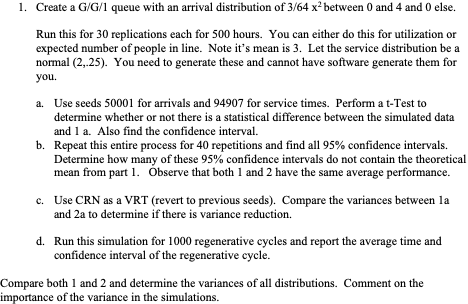